# Preamble

## Imports

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DissimilarityMatrix
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib as mpl
from scipy.spatial.distance import pdist, squareform

from scripts.lib.plotting import load_style
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering


loaded_style = load_style('paper')
savefig = loaded_style['savefig']
fullwidth = loaded_style['fullwidth']
halfwidth = loaded_style['halfwidth']

con = sqlite3.connect('data/core.muri2.2.denorm.db')
#sns.set_context('notebook')

def idxwhere(x):
    return x[x].index

def ident(x):
    return x

In [2]:
def plot_pca_ordination(
    d, meta, xy=('PC1', 'PC2'),
    marker=None, color=None, size=None, annot=None, zorder=None, alpha=None,
    derep_kwargs=dict(linkage='complete', distance_threshold=0.0),
    ax=None,
    scatter_kwargs={},
    textoffset=0.0,
    annot_kwargs=None,
    show_feats = [], feat_scale = 1.0,
    feat_arrow_kwargs=dict(arrowprops=dict(arrowstyle="-", lw=1, color='k')),
    feat_label_kwargs={},
):
    x, y = xy
    if not ax:
        fig, ax = plt.subplots()
    if marker is None:
        marker = lambda m: 'o'
    if color is None:
        color = lambda m: 'black'
    if size is None:
        size = lambda m: 10
    if annot is None:
        annot = lambda m: ''
    if zorder is None:
        zorder = lambda m: 1
    if alpha is None:
        alpha = lambda m: 1
        
    # Fuzzy dereplication of genomes:
    # Drop entries with only zeros.
    is_empty = d.sum(1) == 0
    d_noempty = d[~is_empty]
    
    dmat = pd.DataFrame(squareform(pdist(d_noempty,
                            metric='cosine')
                     ), index=d_noempty.index, columns=d_noempty.index)
    clust = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                    **derep_kwargs,
                                   ).fit_predict(dmat)
    clust = pd.Series(clust, index=d_noempty.index)
    # Add back a cluster for empty items.
    clust = np.concatenate([clust, pd.Series(-1, index=idxwhere(is_empty))])

    # Perform transformation.
    d_fit = d.groupby(clust).mean()
    d_feats = np.eye(d_fit.shape[1])
    fit = PCA().fit(d_fit)
    ordin = pd.DataFrame(fit.transform(d), index=d.index)
    comps = pd.DataFrame(fit.components_.T, index=d.columns)
    ordin.columns = comps.columns = [f'PC{i}' for i in ordin.columns + 1]
    perc_explained = pd.Series(fit.explained_variance_ratio_, index=ordin.columns)

    d0 = (
            ordin
            .join(meta)
            .assign(
                __color=color,
                __size=size,
                __marker=marker,
                __annot=annot,
                __zorder=zorder,
                __alpha=alpha,
            )
        )
    for (marker, zorder, alpha), d1 in d0.groupby(['__marker', '__zorder', '__alpha']):
        ax.scatter(
            x, y,
            data=d1,
            color='__color',
            s='__size',
            marker=marker, zorder=zorder, alpha=alpha,
            **scatter_kwargs,
            label='__nolegend__',
        )
        
    for feat in show_feats:
        _x = feat_scale * comps.loc[feat, x]
        _y = feat_scale * comps.loc[feat, y]
        ax.annotate("", xy=(_x, _y), xytext=(0, 0), **feat_arrow_kwargs, annotation_clip=False)
        ax.annotate(feat, xy=(_x, _y), ha='center', va='center', **feat_label_kwargs)

    xleft, xright = ax.get_xlim()
    ytop, ybottom = ax.get_ylim()
    xwidth = np.abs(xright - xleft)
    yheight = np.abs(ytop - ybottom)
    
    for genome_id, (_x, _y, __annot) in d0[[x, y, '__annot']].iterrows():
        if not __annot:
            continue
        ax.annotate(__annot,
                    xy=(_x, _y),
                    xytext=(textoffset, textoffset), textcoords='offset points',
                    va='center', ha='center', **annot_kwargs)

    ax.set_xlabel('{} ({:.0%})'.format(x, perc_explained[x]))
    ax.set_ylabel('{} ({:.0%})'.format(y, perc_explained[y]))
    return ax, fit, d0, comps

## Metadata

In [3]:
color_map = { 'ormerod-starch': 'blue'
            , 'ormerod-host': 'purple'
            , 'ormerod-plant': 'green'
            , 'public': 'grey'
            , 'here': 'black'
            }
alpha_map = { 'ormerod-starch': 0.5
            , 'ormerod-host': 0.5
            , 'ormerod-plant': 0.5
            , 'public': 0.25
            , 'here': 0.9
            }
subgroups = ['ormerod-plant', 'ormerod-host', 'ormerod-starch', 'here', 'public']
size_map = {'ormerod-plant': 10, 'ormerod-host': 10, 'ormerod-starch': 10, 'public': 10, 'here': 20}
marker_map = {'ormerod-plant': 'o', 'ormerod-host': 'o', 'ormerod-starch': 'o', 'public': 'o', 'here': '^'}
zorder_map = {'ormerod-plant': 1, 'ormerod-host': 1, 'ormerod-starch': 1, 'public': 0, 'here': 2}
label_list = [
                'Homeothermus_arabinoxylanisolvens'
              , 'Muribaculum_intestinale_DSM_28989T'
              , 'Duncaniella_muris_DSM_103720T'
              , 'Duncaniella_freteri_DSM_108168T'
              , 'Duncaniella_dubosii_DSM_107170T'
              , 'Paramuribaculum_intestinale_DSM_100749T'
              , 'Amulumruptor_caecigallinarius'
              ]
#mpl.rcParams['text.usetex'] = True

In [4]:
mag = (
    pd.read_sql(
    """
SELECT *
FROM genome
JOIN checkm USING (genome_id)
JOIN genome_group USING (genome_id)
WHERE genome_group_id = 'muri2'
    """,
    index_col='genome_id',
    con=con,
    )
)

rename_map = {
                 'Barnesiella_viscericola_DSM_18177': 'Bv'
               , 'Bacteroides_ovatus_ATCC_8483': 'Bo'
               , 'Bacteroides_thetaiotaomicron_VPI5482': 'Bt'
               , 'Porphyromonas_gingivalis_ATCC_33277': 'Pg'
               , 'Homeothermus_arabinoxylanisolvens': 'Ha'
               , 'Muribaculum_intestinale_DSM_28989T': 'Mi'
               , 'Duncaniella_muris_DSM_103720T': 'Dm'
               , 'Duncaniella_freteri_DSM_108168T': 'Df'
               , 'Duncaniella_dubosii_DSM_107170T': 'Dd'
               , 'Paramuribaculum_intestinale_DSM_100749T': 'Pi'
               , 'Amulumruptor_caecigallinarius': 'Ac'
               } 

italic_list = [ 'Barnesiella_viscericola_DSM_18177'
              , 'Bacteroides_ovatus_ATCC_8483'
              , 'Bacteroides_thetaiotaomicron_VPI5482'
              , 'Porphyromonas_gingivalis_ATCC_33277'
              , 'Homeothermus_arabinoxylanisolvens'
              , 'Muribaculum_intestinale_DSM_28989T'
              , 'Duncaniella_muris_DSM_103720T'
              , 'Duncaniella_freteri_DSM_108168T'
              , 'Duncaniella_dubosii_DSM_107170T'
              , 'Paramuribaculum_intestinale_DSM_100749T'
              , 'Amulumruptor_caecigallinarius'
              ]

def rename_mag(genome_id):
    if genome_id in rename_map:
        return rename_map[genome_id]
    else:
        return genome_id

In [5]:
opf_to_architecture = pd.read_sql(
    """
SELECT * FROM opf_to_architecture;
    """,
    index_col='opf_id',
    con=con,
).squeeze()

## Domains

### No other filters

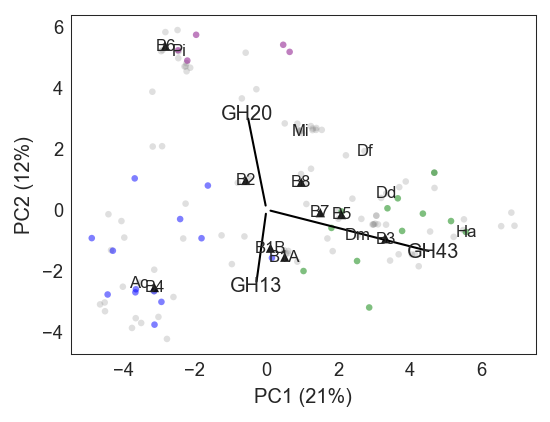

In [6]:
# Glycoside hydrolase tallies as in Ormerod (not counting e.g. GH13_1 separately from GH13_2)

cazy_count = (
    pd.read_sql(
        """
SELECT genome_id, cazy_family AS func_id, COUNT(feature_id) AS tally
FROM (SELECT
          feature_id,
          SUBSTR(domain_id, 0,
                 CASE WHEN INSTR(domain_id, '_')
                      THEN INSTR(domain_id, '_')
                      ELSE LENGTH(domain_id) + 1
                 END) AS cazy_family
      FROM feature_x_cazy_minimal_domain
      WHERE score > 5.
        AND (cazy_family LIKE 'GH%' OR cazy_family LIKE 'CBM%')        
      )
JOIN feature USING (feature_id)
JOIN sequence USING (sequence_id)
-- JOIN (SELECT DISTINCT feature_id, genome_id
--       FROM (SELECT feature_id AS seed_id FROM pul_susC)
--       JOIN feature_distance USING (seed_id)
--       JOIN feature USING (feature_id)
--       JOIN sequence USING (sequence_id)
--       WHERE distance < 10000  -- Choose filter distance from susC or remove entirely
--      ) USING (feature_id)
-- JOIN feature_localization USING (feature_id)
WHERE func_id NOT NULL
--   AND localization IN ('OM', 'IM', 'PP')  -- Choose localization filter
GROUP BY genome_id, func_id
        """,
        con=con, index_col=['genome_id', 'func_id']
        )
        .tally
        .unstack('func_id', fill_value=0)
        .reindex(mag.index)
        .fillna(0)
            )

ax, pca, d0, comps = plot_pca_ordination(
    cazy_count.loc[mag.subgroup.isin(subgroups)].apply(lambda x: np.sqrt(x)),
    xy=('PC1', 'PC2'),
    meta=mag,
    show_feats=['GH13', 'GH43', 'GH20'], feat_scale=10.0,
    derep_kwargs={'linkage': 'complete', 'distance_threshold': 0.1},
    color=lambda m: m.subgroup.map(color_map),
    size=lambda m: m.subgroup.map(size_map),
    marker=lambda m: m.subgroup.map(marker_map),
    zorder=lambda m: m.subgroup.map(zorder_map),
    alpha=lambda m: m.subgroup.map(alpha_map),
    annot=lambda m: (
        m.index.to_series().replace(rename_map)
        .where(
            (
                m.index.to_series().isin(label_list)
                | m.subgroup.isin(['here'])
            ),
            ''
        )
    ),
    scatter_kwargs=dict(linewidths=0),
    annot_kwargs=dict(fontsize=8,
                     ),
    textoffset=0.03,
)

In [7]:
comps['PC2'].sort_values(ascending=False).head(10)

func_id
GH20     0.310906
GH92     0.242933
GH138    0.229774
CBM32    0.224472
GH2      0.192400
CBM13    0.159785
GH29     0.156734
GH109    0.147259
GH110    0.136703
GH84     0.128530
Name: PC2, dtype: float64

In [8]:
comps['PC2'].sort_values(ascending=True)

func_id
CBM26   -0.367854
GH13    -0.248772
CBM69   -0.209102
CBM4    -0.161120
CBM48   -0.144065
           ...   
GH2      0.192400
CBM32    0.224472
GH138    0.229774
GH92     0.242933
GH20     0.310906
Name: PC2, Length: 205, dtype: float64

<AxesSubplot:xlabel='subgroup', ylabel='total_cazy_domain_proteins'>

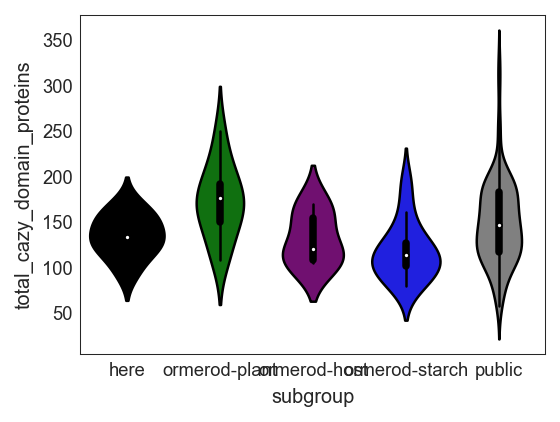

In [9]:
sns.violinplot(
    x='subgroup', y='total_cazy_domain_proteins',
    data=mag.assign(total_cazy_domain_proteins=cazy_count.sum(1))[~(mag.subgroup == 'outgroup')],
    palette=color_map,
)

### Exported

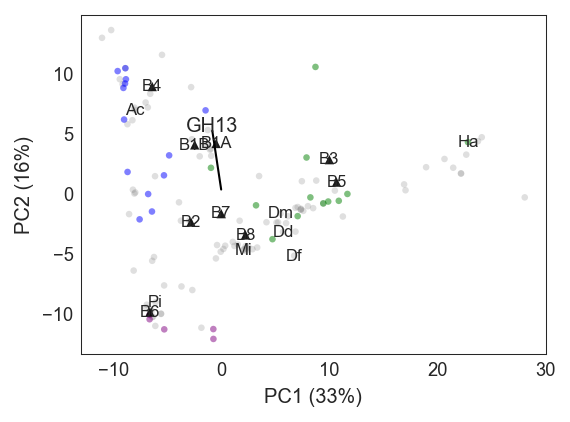

In [10]:
# Exported glycoside hydrolase domains
cazy_export_count = (
    pd.read_sql(
        """
SELECT genome_id, cazy_family AS func_id, COUNT(feature_id) AS tally
FROM (SELECT
          feature_id,
          SUBSTR(domain_id, 0,
                 CASE WHEN INSTR(domain_id, '_')
                      THEN INSTR(domain_id, '_')
                      ELSE LENGTH(domain_id) + 1
                 END) AS cazy_family
      FROM feature_x_cazy_minimal_domain
      WHERE score > 5.
        AND (cazy_family LIKE 'GH%' OR cazy_family LIKE 'CBM%')        
      )
JOIN feature USING (feature_id)
JOIN sequence USING (sequence_id)
-- JOIN (SELECT DISTINCT feature_id
--       FROM (SELECT feature_id AS seed_id FROM pul_susC)
--       JOIN feature_distance USING (seed_id)
--       JOIN feature USING (feature_id)
--       JOIN sequence USING (sequence_id)
--       WHERE distance < 10000  -- Choose filter distance from susC or remove entirely
--      ) USING (feature_id)
JOIN feature_localization USING (feature_id)
WHERE func_id NOT NULL
  AND localization IN ('OM', 'IM', 'PP')  -- Choose localization filter
GROUP BY genome_id, func_id
        """,
        con=con, index_col=['genome_id', 'func_id']
        )
        .tally
        .unstack('func_id', fill_value=0)
        .reindex(mag.index)
        .fillna(0)
            )


d = cazy_export_count

ax, pca, d0, comps = plot_pca_ordination(
    d.loc[mag.subgroup.isin(subgroups)].apply(lambda x: x),
    xy=('PC1', 'PC2'),
    meta=mag,
    show_feats=['GH13'], feat_scale=10.0,
    derep_kwargs={'linkage': 'complete', 'distance_threshold': 0.1},
    color=lambda m: m.subgroup.map(color_map),
    size=lambda m: m.subgroup.map(size_map),
    marker=lambda m: m.subgroup.map(marker_map),
    zorder=lambda m: m.subgroup.map(zorder_map),
    alpha=lambda m: m.subgroup.map(alpha_map),
    annot=lambda m: (
        m.index.to_series().replace(rename_map)
        .where(
            (
                m.index.to_series().isin(label_list)
                | m.subgroup.isin(['here'])
            ),
            ''
        )
    ),
    scatter_kwargs=dict(linewidths=0),
    annot_kwargs=dict(fontsize=8,
                     ),
    textoffset=0.03,
)

### In PUL

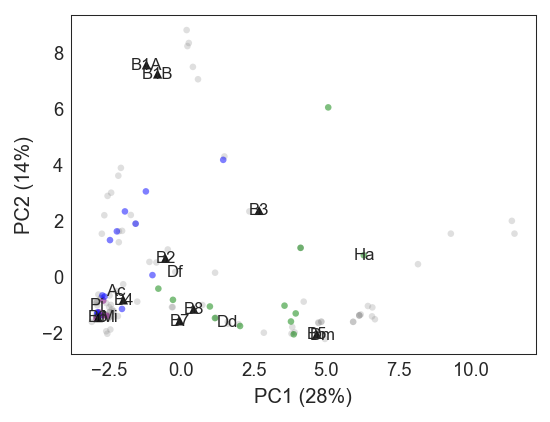

In [11]:
# Exported glycoside hydrolase domains
cazy_pul_count = (
    pd.read_sql(
        """
SELECT genome_id, cazy_family AS func_id, COUNT(feature_id) AS tally
FROM (SELECT
          feature_id,
          SUBSTR(domain_id, 0,
                 CASE WHEN INSTR(domain_id, '_')
                      THEN INSTR(domain_id, '_')
                      ELSE LENGTH(domain_id) + 1
                 END) AS cazy_family
      FROM feature_x_cazy_minimal_domain
      WHERE score > 5.
        AND (cazy_family LIKE 'GH%' OR cazy_family LIKE 'CBM%')        
      )
JOIN feature USING (feature_id)
JOIN sequence USING (sequence_id)
JOIN (SELECT feature_id FROM closest_PUL_susC WHERE distance < 10000) USING (feature_id)
-- JOIN feature_localization USING (feature_id)
WHERE func_id NOT NULL
--   AND localization IN ('OM', 'IM', 'PP')  -- Choose localization filter
GROUP BY genome_id, func_id
        """,
        con=con, index_col=['genome_id', 'func_id']
        )
        .tally
        .unstack('func_id', fill_value=0)
        .reindex(mag.index)
        .fillna(0)
            )

d = cazy_pul_count

ax, pca, d0, comps = plot_pca_ordination(
    cazy_pul_count.loc[mag.subgroup.isin(subgroups)].apply(lambda x: x),
    xy=('PC1', 'PC2'),
    meta=mag,
    show_feats=[], feat_scale=20.0,
    derep_kwargs={'linkage': 'complete', 'distance_threshold': 0.1},
    color=lambda m: m.subgroup.map(color_map),
    size=lambda m: m.subgroup.map(size_map),
    marker=lambda m: m.subgroup.map(marker_map),
    zorder=lambda m: m.subgroup.map(zorder_map),
    alpha=lambda m: m.subgroup.map(alpha_map),
    annot=lambda m: (
        m.index.to_series().replace(rename_map)
        .where(
            (
                m.index.to_series().isin(label_list)
                | m.subgroup.isin(['here'])
            ),
            ''
        )
    ),
    scatter_kwargs=dict(linewidths=0),
    annot_kwargs=dict(fontsize=8,
                     ),
    textoffset=0.03,
)

### Exported and PUL localized

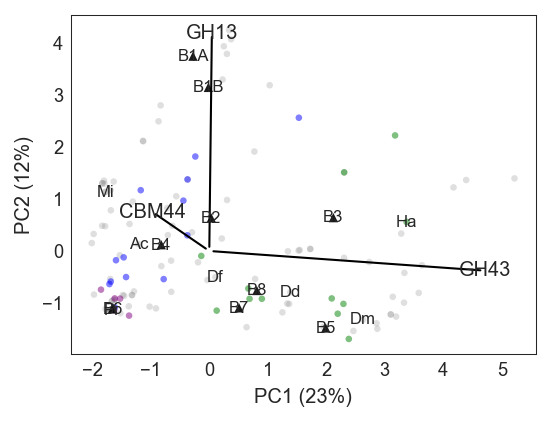

In [12]:
# Exported glycoside hydrolase domains
cazy_pul_export_count = (
    pd.read_sql(
        """
SELECT genome_id, cazy_family AS func_id, COUNT(feature_id) AS tally
FROM (SELECT
          feature_id,
          SUBSTR(domain_id, 0,
                 CASE WHEN INSTR(domain_id, '_')
                      THEN INSTR(domain_id, '_')
                      ELSE LENGTH(domain_id) + 1
                 END) AS cazy_family
      FROM feature_x_cazy_minimal_domain
      WHERE score > 5.
        AND (cazy_family LIKE 'GH%' OR cazy_family LIKE 'CBM%')        
      )
JOIN feature USING (feature_id)
JOIN sequence USING (sequence_id)
JOIN (SELECT feature_id FROM closest_PUL_susC WHERE distance < 10000) USING (feature_id)
JOIN feature_localization USING (feature_id)
WHERE func_id NOT NULL
  AND localization IN ('OM', 'IM', 'PP')  -- Choose localization filter
GROUP BY genome_id, func_id
        """,
        con=con, index_col=['genome_id', 'func_id']
        )
        .tally
        .unstack('func_id', fill_value=0)
        .reindex(mag.index)
        .fillna(0)
            )

d = cazy_pul_export_count

ax, pca, d0, comps = plot_pca_ordination(
    d.loc[mag.subgroup.isin(subgroups)].apply(lambda x: np.sqrt(x)),
    xy=('PC1', 'PC2'),
    meta=mag,
    show_feats=['GH13', 'GH43', 'CBM44'], feat_scale=10.0,
    derep_kwargs={'linkage': 'complete', 'distance_threshold': 0.1},
    color=lambda m: m.subgroup.map(color_map),
    size=lambda m: m.subgroup.map(size_map),
    marker=lambda m: m.subgroup.map(marker_map),
    zorder=lambda m: m.subgroup.map(zorder_map),
    alpha=lambda m: m.subgroup.map(alpha_map),
    annot=lambda m: (
        m.index.to_series().replace(rename_map)
        .where(
            (
                m.index.to_series().isin(label_list)
                | m.subgroup.isin(['here'])
            ),
            ''
        )
    ),
    scatter_kwargs=dict(linewidths=0),
    annot_kwargs=dict(fontsize=8,
                     ),
    textoffset=0.03,
)

In [13]:
comps['PC1'].sort_values(ascending=False).tail(10)

func_id
GH119   -0.019938
GH109   -0.020780
CBM48   -0.034170
CBM36   -0.038900
GH123   -0.046365
GH18    -0.049149
GH33    -0.055064
CBM40   -0.063914
GH85    -0.077284
CBM44   -0.097490
Name: PC1, dtype: float64

In [14]:
comps['PC2'].sort_values(ascending=False).tail(10)

func_id
GH140   -0.023072
GH5     -0.036215
GH43    -0.037683
CBM23   -0.037734
CBM6    -0.042937
GH51    -0.048327
GH26    -0.081539
GH28    -0.087192
CBM4    -0.106929
GH10    -0.139123
Name: PC2, dtype: float64

## OPF clusters

### No other filters

### Exported

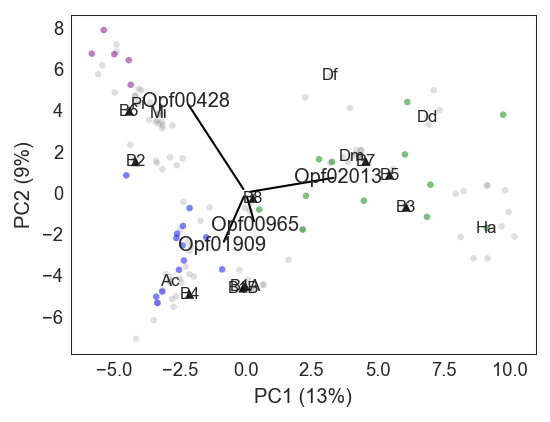

In [16]:
# Exported glycoside hydrolase domains
opf_cazy_export_count = (
    pd.read_sql(
        """
SELECT genome_id, opf_id AS func_id, COUNT(feature_id) AS tally
FROM (SELECT
          feature_id,
          SUBSTR(domain_id, 0,
                 CASE WHEN INSTR(domain_id, '_')
                      THEN INSTR(domain_id, '_')
                      ELSE LENGTH(domain_id) + 1
                 END) AS cazy_family
      FROM feature_x_cazy_minimal_domain
      WHERE score > 5.
        AND (cazy_family LIKE 'GH%' OR cazy_family LIKE 'CBM%')        
      )
JOIN feature USING (feature_id)
JOIN feature_to_opf USING (feature_id)
JOIN sequence USING (sequence_id)
-- JOIN (SELECT DISTINCT feature_id
--       FROM (SELECT feature_id AS seed_id FROM pul_susC)
--       JOIN feature_distance USING (seed_id)
--       JOIN feature USING (feature_id)
--       JOIN sequence USING (sequence_id)
--       WHERE distance < 10000  -- Choose filter distance from susC or remove entirely
--      ) USING (feature_id)
JOIN feature_localization USING (feature_id)
WHERE func_id NOT NULL
  AND localization IN ('OM', 'IM', 'PP')  -- Choose localization filter
GROUP BY genome_id, func_id
        """,
        con=con, index_col=['genome_id', 'func_id']
        )
        .tally
        .unstack('func_id', fill_value=0)
        .reindex(mag.index)
        .fillna(0)
            )

d = opf_cazy_export_count

ax, pca, d0, comps = plot_pca_ordination(
    d.loc[mag.subgroup.isin(subgroups)].apply(lambda x: x),
    xy=('PC1', 'PC2'),
    meta=mag,
    show_feats=['Opf01909', 'Opf00965', 'Opf02013', 'Opf00428'], feat_scale=10.0,
    derep_kwargs={'linkage': 'complete', 'distance_threshold': 0.1},
    color=lambda m: m.subgroup.map(color_map),
    size=lambda m: m.subgroup.map(size_map),
    marker=lambda m: m.subgroup.map(marker_map),
    zorder=lambda m: m.subgroup.map(zorder_map),
    alpha=lambda m: m.subgroup.map(alpha_map),
    annot=lambda m: (
        m.index.to_series().replace(rename_map)
        .where(
            (
                m.index.to_series().isin(label_list)
                | m.subgroup.isin(['here'])
            ),
            ''
        )
    ),
    scatter_kwargs=dict(linewidths=0),
    annot_kwargs=dict(fontsize=8,
                     ),
    textoffset=0.03,
)

In [17]:
comps['PC1'].sort_values()

func_id
Opf00428   -0.226495
Opf02379   -0.119316
Opf02388   -0.099543
Opf01909   -0.089094
Opf03190   -0.084605
              ...   
Opf04335    0.165881
Opf01321    0.174666
Opf01365    0.227332
Opf02013    0.348123
Opf01132    0.386067
Name: PC1, Length: 992, dtype: float64

In [18]:
opf_to_architecture.loc['Opf01132']

architecture    Glyco_hydro_43:CBM_6
fraction                    0.910891
out_of                           101
Name: Opf01132, dtype: object

In [19]:
opf_to_architecture.loc[comps['PC2'].sort_values().head(10).index]

,architecture,fraction,out_of
func_id,,,
Opf01909,CBM26:Alpha-amylase:CBM26:Alpha-amylase:CBM26:...,0.432432,37
Opf01768,Bac_rhamnosid6H:GDE_C:CBM_6:CBM_6,0.181818,44
Opf02388,gerPA:Alpha-amylase:Alpha-amylase:CarboxypepD_...,0.120000,25
Opf03190,Alpha-amylase:CBM26:CBM26:CHB_HEX_C_1:Alpha-am...,0.250000,16
Opf00965,Alpha-amylase:Alpha-amylase,0.326316,95
Opf03199,CBM26:CBM26:CBM26,0.470588,17
Opf02584,SusF_SusE:SusF_SusE:SusF_SusE:SusF_SusE,0.575758,33
Opf02141,Laminin_G_3:Glyco_hydro_32N:Glyco_hydro_32C,0.500000,34
Opf02205,Alpha-amylase:Alpha-amyl_C2,0.259259,27


In [20]:
opf_to_architecture.loc[['Opf01909', 'Opf01768', 'Opf02388', 'Opf03190', 'Opf00965', 'Opf03199', 'Opf02584']]

,architecture,fraction,out_of
opf_id,,,
Opf01909,CBM26:Alpha-amylase:CBM26:Alpha-amylase:CBM26:...,0.432432,37
Opf01768,Bac_rhamnosid6H:GDE_C:CBM_6:CBM_6,0.181818,44
Opf02388,gerPA:Alpha-amylase:Alpha-amylase:CarboxypepD_...,0.120000,25
Opf03190,Alpha-amylase:CBM26:CBM26:CHB_HEX_C_1:Alpha-am...,0.250000,16
Opf00965,Alpha-amylase:Alpha-amylase,0.326316,95
Opf03199,CBM26:CBM26:CBM26,0.470588,17
Opf02584,SusF_SusE:SusF_SusE:SusF_SusE:SusF_SusE,0.575758,33


In [21]:
d[['Opf01909', 'Opf01768', 'Opf02388', 'Opf03190', 'Opf00965', 'Opf03199', 'Opf02584', 'Opf02888']]

func_id,Opf01909,Opf01768,Opf02388,Opf03190,Opf00965,Opf03199,Opf02584,Opf02888
genome_id,,,,,,,,
B1A,0,5,0,0,2,3,2,1
B1B,0,5,0,0,2,3,4,1
B2,0,4,3,0,1,0,0,0
B3,0,0,0,0,2,0,4,0
B4,3,5,4,4,4,0,0,0
...,...,...,...,...,...,...,...,...
GCA_902406015,6,4,0,0,2,0,0,0
Barnesiella_viscericola_DSM_18177,0,0,0,0,0,0,1,0
Porphyromonas_gingivalis_ATCC_33277,0,0,0,0,0,0,0,0


In [22]:
opf_of_interest = idxwhere(
    (d.loc['B1A'] > 0)
    & (d.loc['B2'] > 0)
    & (d.loc[['B3', 'B4', 'B5', 'B6', 'B7', 'B8']] == 0).all()
)

In [23]:
d[opf_of_interest]

func_id,Opf01407,Opf01739,Opf01765,Opf01951,Opf02050
genome_id,,,,,
B1A,1,3,1,1,1
B1B,1,1,1,0,1
B2,1,1,1,1,1
B3,0,0,0,0,0
B4,0,0,0,0,0
...,...,...,...,...,...
GCA_902406015,0,0,1,0,0
Barnesiella_viscericola_DSM_18177,0,0,0,0,0
Porphyromonas_gingivalis_ATCC_33277,0,0,0,0,0


In [24]:
opf_to_architecture.loc[opf_of_interest]

,architecture,fraction,out_of
func_id,,,
Opf01407,DUF4493:Pur_ac_phosph_N:PCMD,0.161290,62
Opf01739,Glyco_hydro_53:Glyco_hydro_53,0.711538,52
Opf01765,Cyc-maltodext_N:Alpha-amylase:Cyc-maltodext_C,0.936170,47
Opf01951,CarboxypepD_reg:SASA:Glyco_hydro_2_N:SASA,0.243243,37
Opf02050,Glyco_hydro_16,0.818182,33


In [25]:
comps['PC2'].sort_values(ascending=False).head(20)

func_id
Opf00428    0.443865
Opf02379    0.177621
Opf01132    0.135291
Opf02135    0.135179
Opf02577    0.125301
Opf04999    0.115984
Opf01321    0.111272
Opf00023    0.106760
Opf03489    0.104373
Opf01265    0.104228
Opf01060    0.100267
Opf00076    0.097421
Opf01108    0.088915
Opf02143    0.088397
Opf07087    0.081286
Opf01375    0.081029
Opf01688    0.080170
Opf03482    0.077979
Opf02013    0.074441
Opf02047    0.071143
Name: PC2, dtype: float64

In [26]:
opf_to_architecture.loc[['Opf00428', 'Opf02379', 'Opf00076', 'Opf01060', 'Opf02135', 'Opf01108']]

,architecture,fraction,out_of
opf_id,,,
Opf00428,Glyco_hydro_20b:Glyco_hydro_20:Fn3_assoc:F5_F8...,0.297101,138
Opf02379,Glyco_hydro_20b:NAGidase:NAGidase:F5_F8_type_C,0.416667,48
Opf00076,Glyco_hydro_2_N:Glyco_hydro_2:Glyco_hydro_2_C:...,0.781250,160
Opf01060,Glyco_hydro_92,0.933333,90
Opf02135,Alpha_L_fucos:F5_F8_type_C:F5_F8_type_C,0.853659,41
Opf01108,Glyco_hyd_65N_2,0.297872,94


In [27]:
(mag.completeness / 100).min()

0.8094

### Exported and PUL localized

# Figure

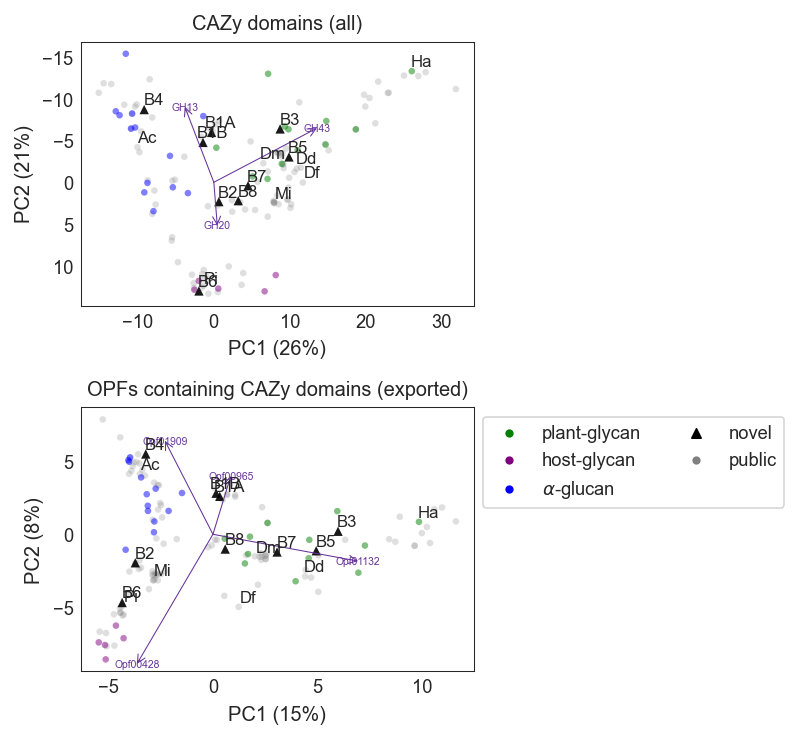

In [28]:
dd = [
    ('CAZy domains (all)', cazy_count, ('PC1', 'PC2'), ['GH13', 'GH20', 'GH43'], False, True),
    ('OPFs containing CAZy domains (exported)', opf_cazy_export_count, ('PC1', 'PC2'), ['Opf01909', 'Opf00965', 'Opf01132', 'Opf00428'], False, False),
]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(halfwidth, halfwidth * 1.5))
axs = np.asarray(axs)

for (title, d, xy, show_feats, flipx, flipy), ax in zip(dd, axs.flatten()):
    ax, pca, d0, comps = plot_pca_ordination(
        d.loc[mag.subgroup.isin(subgroups)].apply(lambda x: x),
        derep_kwargs={'linkage': 'complete', 'distance_threshold': 0.2},
        xy=xy,
        meta=mag,
        show_feats=show_feats, feat_scale=20.0,
        feat_arrow_kwargs=dict(arrowprops=dict(arrowstyle="->", lw=0.5, color='rebeccapurple', shrinkA=0, shrinkB=0)),
        feat_label_kwargs=dict(color='rebeccapurple', fontsize=5),
        color=lambda m: m.subgroup.map(color_map),
        size=lambda m: m.subgroup.map(size_map),
        marker=lambda m: m.subgroup.map(marker_map),
        zorder=lambda m: m.subgroup.map(zorder_map),
        alpha=lambda m: m.subgroup.map(alpha_map),
        annot=lambda m: (
            m.index.to_series().replace(rename_map)
            .where(
                (
                    m.index.to_series().isin(label_list)
                    | m.subgroup.isin(['here'])
                ),
                ''
            )
        ),
        scatter_kwargs=dict(linewidths=0),
        annot_kwargs=dict(fontsize=8,
#                           arrowprops=dict(lw=0.3, color='k', arrowstyle='->'),
#                           bbox=dict(pad=-3, facecolor="none", edgecolor="none")
                         ),
        textoffset=4.5,
        ax=ax
    )
    ax.set_title(title)
    if flipx:
        ax.invert_xaxis()
    if flipy:
        ax.invert_yaxis()
    
legend_map = {'public': 'public', 'ormerod-starch': '$\\alpha$-glucan',
              'ormerod-host': 'host-glycan', 'ormerod-plant': 'plant-glycan',
              'here': 'novel'}
for subgroup in subgroups:
    ax.scatter([], [], s=size_map[subgroup], c=color_map[subgroup], marker=marker_map[subgroup], label=legend_map[subgroup])

fig.tight_layout()

ax.legend(ncol=2, bbox_to_anchor=(1, 1))
fig.savefig('fig/cazy_ordination.pdf', bbox_inches='tight', )

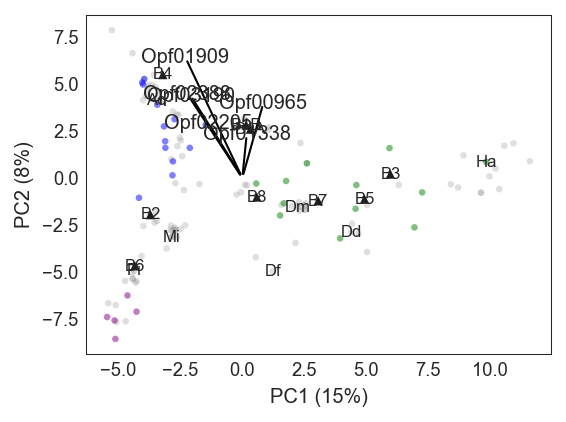

In [29]:
ax, pca, d0, comps = plot_pca_ordination(
    opf_cazy_export_count.loc[mag.subgroup.isin(subgroups)].apply(lambda x: x),
    xy=('PC1', 'PC2'),
    meta=mag,
    show_feats=['Opf01909', 'Opf02388', 'Opf03190', 'Opf00965', 'Opf02205', 'Opf01338'], feat_scale=20.0,
    derep_kwargs={'linkage': 'complete', 'distance_threshold': 0.2},
    color=lambda m: m.subgroup.map(color_map),
    size=lambda m: m.subgroup.map(size_map),
    marker=lambda m: m.subgroup.map(marker_map),
    zorder=lambda m: m.subgroup.map(zorder_map),
    alpha=lambda m: m.subgroup.map(alpha_map),
    annot=lambda m: (
        m.index.to_series().replace(rename_map)
        .where(
            (
                m.index.to_series().isin(label_list)
                | m.subgroup.isin(['here'])
            ),
            ''
        )
    ),
    scatter_kwargs=dict(linewidths=0),
    annot_kwargs=dict(fontsize=8,
                     ),
    textoffset=0.03,
)

In [30]:
comps['PC2'].to_frame().join(opf_to_architecture).sort_values('PC2')

,PC2,architecture,fraction,out_of
func_id,,,,
Opf00428,-0.443550,Glyco_hydro_20b:Glyco_hydro_20:Fn3_assoc:F5_F8...,0.297101,138
Opf02379,-0.171615,Glyco_hydro_20b:NAGidase:NAGidase:F5_F8_type_C,0.416667,48
Opf04999,-0.144988,DUF4968:DUF5110:Gal_mutarotas_2:Glyco_hydro_31...,0.533333,15
Opf02577,-0.123999,Bgal_small_N:Glyco_hydro_2_N:Glyco_hydro_2:Gly...,0.320000,25
Opf02135,-0.123225,Alpha_L_fucos:F5_F8_type_C:F5_F8_type_C,0.853659,41
...,...,...,...,...
Opf01768,0.188826,Bac_rhamnosid6H:GDE_C:CBM_6:CBM_6,0.181818,44
Opf00965,0.199552,Alpha-amylase:Alpha-amylase,0.326316,95
Opf03190,0.217726,Alpha-amylase:CBM26:CBM26:CHB_HEX_C_1:Alpha-am...,0.250000,16


In [31]:
comps['PC1'].to_frame().join(opf_to_architecture).sort_values('PC1')

,PC1,architecture,fraction,out_of
func_id,,,,
Opf00428,-0.181693,Glyco_hydro_20b:Glyco_hydro_20:Fn3_assoc:F5_F8...,0.297101,138
Opf01909,-0.114791,CBM26:Alpha-amylase:CBM26:Alpha-amylase:CBM26:...,0.432432,37
Opf02388,-0.110774,gerPA:Alpha-amylase:Alpha-amylase:CarboxypepD_...,0.120000,25
Opf03190,-0.103864,Alpha-amylase:CBM26:CBM26:CHB_HEX_C_1:Alpha-am...,0.250000,16
Opf02379,-0.079005,Glyco_hydro_20b:NAGidase:NAGidase:F5_F8_type_C,0.416667,48
...,...,...,...,...
Opf02724,0.172254,Glyco_hydro_43:CBM_6:Glyco_hydro_8,0.941176,17
Opf01862,0.193632,Glyco_hydro_35:BetaGal_dom4_5:BetaGal_dom4_5:F...,0.457143,35
Opf01365,0.262247,CBM_4_9:Alpha-L-AF_C,0.835821,67


In [32]:
(opf_cazy_export_count[['Opf01909', 'Opf00965']] > 0).groupby(mag.subgroup).sum().assign(total=mag.subgroup.value_counts())

func_id,Opf01909,Opf00965,total
subgroup,,,
here,1,7,9
ormerod-host,0,0,5
ormerod-plant,1,11,12
ormerod-starch,6,10,13
outgroup,0,0,5
public,15,54,98


In [33]:
(opf_cazy_export_count[['Opf01909', 'Opf00965']])[mag.subgroup == 'here']

func_id,Opf01909,Opf00965
genome_id,,
B1A,0,2
B1B,0,2
B2,0,1
B3,0,2
B4,3,4
B5,0,2
B6,0,0
B7,0,2
B8,0,0


In [34]:
opf_to_architecture.loc[['Opf01909', 'Opf00965', 'Opf00428']]

,architecture,fraction,out_of
opf_id,,,
Opf01909,CBM26:Alpha-amylase:CBM26:Alpha-amylase:CBM26:...,0.432432,37
Opf00965,Alpha-amylase:Alpha-amylase,0.326316,95
Opf00428,Glyco_hydro_20b:Glyco_hydro_20:Fn3_assoc:F5_F8...,0.297101,138


/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


<AxesSubplot:xlabel='domain_id', ylabel='feature_id'>

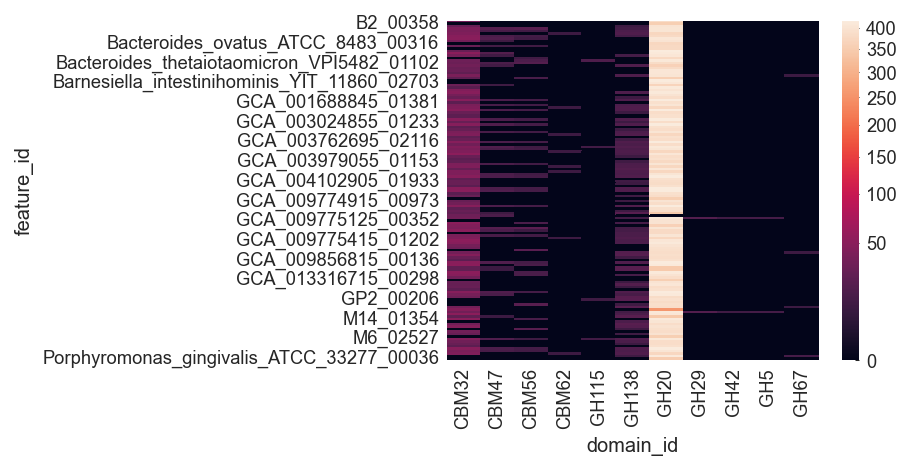

In [35]:
opf00428_domains = pd.read_sql("""
SELECT feature_id, domain_id, score, domain_start, domain_stop
FROM feature_details
LEFT JOIN (SELECT * FROM feature_x_cazy_domain) USING (feature_id)
WHERE opf_id IN ('Opf00428')
  AND score > 10
""", con=con, index_col=['feature_id', 'domain_id'])

sns.heatmap(opf00428_domains.score.unstack(fill_value=0), norm=mpl.colors.PowerNorm(1/2))

In [36]:
opf00428_domains[['domain_start', 'domain_stop']].stack().unstack([-2, -1])[['GH20', 'CBM32', 'GH138']]#.unstack('domain_stop')

domain_id                                             GH20              \
                                              domain_start domain_stop   
feature_id                                                               
B2_00358                                             158.0       511.0   
B2_00850                                             161.0       517.0   
B2_01282                                             143.0       491.0   
B5_00193                                             145.0       502.0   
B6_00320                                             214.0       570.0   
...                                                    ...         ...   
Muribaculum_intestinale_DSM_28989T_02256             153.0       509.0   
Paramuribaculum_intestinale_DSM_100749T_00203        189.0       545.0   
Paramuribaculum_intestinale_DSM_100749T_02457        141.0       490.0   
Porphyromonas_gingivalis_ATCC_33277_00036            165.0       505.0   
Unclassified_Muribaculaceae_DSM_108610_01637         138.0       490.0   

domain_id                                            CBM32              \
                                              domain_start domain_stop   
feature_id                                                               
B2_00358                                             636.0       750.0   
B2_00850                                               NaN         NaN   
B2_01282                                             557.0       668.0   
B5_00193                                             629.0       739.0   
B6_00320                                             701.0       806.0   
...                                                    ...         ...   
Muribaculum_intestinale_DSM_28989T_02256             631.0       750.0   
Paramuribaculum_intestinale_DSM_100749T_00203        676.0       781.0   
Paramuribaculum_intestinale_DSM_100749T_02457        554.0       669.0   
Porphyromonas_gingivalis_ATCC_33277_00036              NaN         NaN   
Unclassified_Muribaculaceae_DSM_108610_01637           NaN         NaN   

domain_id                                            GH138              
                                              domain_start domain_stop  
feature_id                                                              
B2_00358                                               NaN         NaN  
B2_00850                                               NaN         NaN  
B2_01282                                              98.0       159.0  
B5_00193                                              90.0       163.0  
B6_00320                                             164.0       231.0  
...                                                    ...         ...  
Muribaculum_intestinale_DSM_28989T_02256              95.0       169.0  
Paramuribaculum_intestinale_DSM_100749T_00203        139.0       206.0  
Paramuribaculum_intestinale_DSM_100749T_02457         95.0       161.0  
Porphyromonas_gingivalis_ATCC_33277_00036            106.0       179.0  
Unclassified_Muribaculaceae_DSM_108610_01637           NaN         NaN  

[138 rows x 6 columns]

In [37]:
opf00428_domains.score.unstack('domain_id', fill_value=0)['GH20'].sort_values()

feature_id
GCA_009775005_00973                               0.0
H6_01688                                        258.9
M14_01354                                       345.3
GCA_009775005_00889                             346.7
GCA_013316545_00125                             346.7
                                                ...  
GCA_001688845_01381                             416.7
GCA_902362735_01475                             416.7
GCA_009856815_02635                             416.7
GCA_004793655_00394                             416.7
Barnesiella_intestinihominis_YIT_11860_02703    417.5
Name: GH20, Length: 138, dtype: float64

/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


<AxesSubplot:xlabel='domain_id', ylabel='feature_id'>

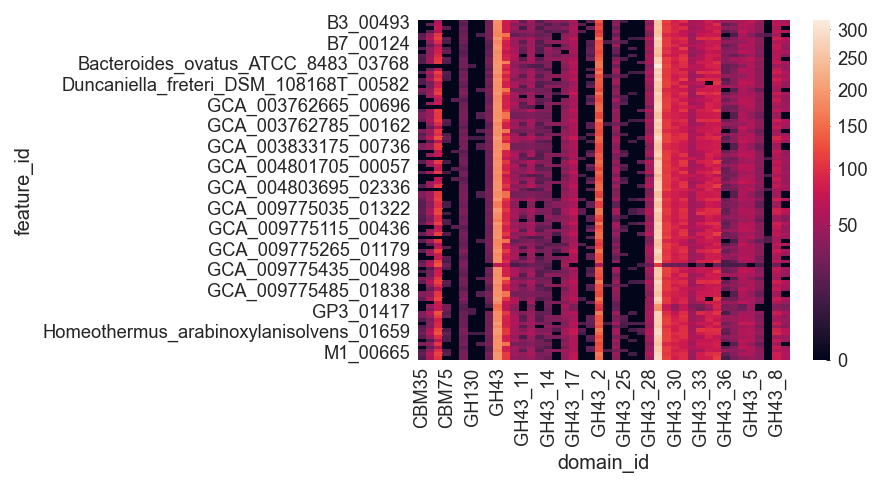

In [38]:
opf01132_domains = pd.read_sql("""
SELECT feature_id, domain_id, score, domain_start, domain_stop
FROM feature_details
LEFT JOIN (SELECT * FROM feature_x_cazy_domain) USING (feature_id)
WHERE opf_id IN ('Opf01132')
  AND score > 10
""", con=con, index_col=['feature_id', 'domain_id'])

sns.heatmap(opf01132_domains.score.groupby(level=['feature_id', 'domain_id']).max().unstack(fill_value=0), norm=mpl.colors.PowerNorm(1/2))

In [41]:
comps['PC2'].sort_values(ascending=True).head()

func_id
Opf00428   -0.443550
Opf02379   -0.171615
Opf04999   -0.144988
Opf02577   -0.123999
Opf02135   -0.123225
Name: PC2, dtype: float64

In [42]:
comps['PC2'].sort_values(ascending=False).head(10)

func_id
Opf01909    0.320020
Opf02388    0.222354
Opf03190    0.217726
Opf00965    0.199552
Opf01768    0.188826
Opf02205    0.145551
Opf02141    0.136719
Opf01338    0.116920
Opf05857    0.112887
Opf03199    0.112025
Name: PC2, dtype: float64

In [43]:
d['Opf00428']

genome_id
B1A                                        0
B1B                                        0
B2                                         6
B3                                         0
B4                                         0
                                          ..
GCA_902406015                              0
Barnesiella_viscericola_DSM_18177          6
Porphyromonas_gingivalis_ATCC_33277        2
Bacteroides_ovatus_ATCC_8483              10
Barnesiella_intestinihominis_YIT_11860    11
Name: Opf00428, Length: 142, dtype: int64

# Features distinguishing responders

In [44]:
pd.read_sql("""
SELECT DISTINCT genome_id, feature_id, localization, product_description, domain_id, score, subgroup, coverage_ratio
FROM feature_details
JOIN feature_x_cazy_minimal_domain USING (feature_id)
JOIN sequence USING (sequence_id)
JOIN genome_group USING (genome_id)
LEFT JOIN variant_cross_coverage USING (genome_id, feature_id)
WHERE localization IN ('OM', 'IM')
  AND (domain_id LIKE 'GH13%' OR domain_id LIKE 'GH66%')
  AND score > 5
  AND subgroup = 'here'
  ;
""", con=con)

,genome_id,feature_id,localization,product_description,domain_id,score,subgroup,coverage_ratio
0,B1A,B1A_00239,IM,SusD-like protein P38,GH13_6,15.9,here,0.998046
1,B1A,B1A_00986,OM,hypothetical protein,GH13_37,9.7,here,0.083640
2,B1A,B1A_01660,OM,Isomalto-dextranase,GH13,19.4,here,1.006135
3,B1A,B1A_01692,OM,Neopullulanase,GH13,126.7,here,1.036585
4,B1A,B1A_02267,OM,Isomalto-dextranase,GH13,22.7,here,1.023899
5,B1B,B1B_01504,OM,Isomalto-dextranase,GH13,19.4,here,1.074650
6,B1B,B1B_01538,OM,Neopullulanase,GH13,126.7,here,1.043818
7,B1B,B1B_02118,OM,Isomalto-dextranase,GH13,22.7,here,1.055494
8,B2,B2_02191,OM,hypothetical protein,GH66,605.3,here,NaN
9,B2,B2_02233,OM,hypothetical protein,GH130,275.5,here,NaN


In [45]:
pd.read_sql("""
SELECT DISTINCT genome_id, feature_id, localization, product_description, subgroup, coverage_ratio
FROM feature_details
JOIN sequence USING (sequence_id)
JOIN genome_group USING (genome_id)
LEFT JOIN variant_cross_coverage USING (genome_id, feature_id)
  WHERE opf_id = 'Opf01405'
  ;
""", con=con).head(20)

,genome_id,feature_id,localization,product_description,subgroup,coverage_ratio
0,B1A,B1A_02263,PP,hypothetical protein,here,0.995164
1,B1B,B1B_02114,PP,hypothetical protein,here,1.083363
2,B2,B2_01846,CY,hypothetical protein,here,NaN
3,B2,B2_02195,PP,hypothetical protein,here,NaN
4,B3,B3_00517,PP,hypothetical protein,here,NaN
5,H10,H10_00553,PP,hypothetical protein,ormerod-starch,NaN
6,H7,H7_01177,PP,hypothetical protein,ormerod-plant,NaN
7,K1,K1_01110,CY,hypothetical protein,ormerod-plant,NaN
8,K1,K1_02804,CY,hypothetical protein,ormerod-plant,NaN
9,M10,M10_01403,CY,hypothetical protein,ormerod-starch,NaN


In [46]:
pd.read_sql("""
SELECT DISTINCT genome_id, feature_id, opf_id, ko_id, localization, product_description, subgroup, coverage_ratio
FROM feature_details
JOIN sequence USING (sequence_id)
JOIN genome_group USING (genome_id)
LEFT JOIN feature_x_ko USING (feature_id)
LEFT JOIN variant_cross_coverage USING (genome_id, feature_id)
  WHERE ko_id = 'K21575'
  ;
""", con=con)

,genome_id,feature_id,opf_id,ko_id,localization,product_description,subgroup,coverage_ratio
0,B1A,B1A_02335,Opf01765,K21575,PP,"1,4-alpha-glucan branching enzyme GlgB",here,1.031847
1,B1B,B1B_02212,Opf01765,K21575,PP,"1,4-alpha-glucan branching enzyme GlgB",here,1.044211
2,B2,B2_00199,Opf01765,K21575,PP,Maltogenic alpha-amylase,here,NaN
3,GP1,GP1_01247,Opf01765,K21575,PP,"1,4-alpha-glucan branching enzyme GlgB",ormerod-plant,NaN
4,GP3,GP3_01850,Opf01765,K21575,CY,Beta/alpha-amylase,ormerod-plant,NaN
5,GP4,GP4_02155,Opf01765,K21575,PP,"1,4-alpha-glucan branching enzyme GlgB",ormerod-plant,NaN
6,H1,H1_01291,Opf01765,K21575,PP,Cyclomaltodextrin glucanotransferase,ormerod-starch,NaN
7,H10,H10_00380,Opf01765,K21575,PP,"1,4-alpha-glucan branching enzyme GlgB",ormerod-starch,NaN
8,H2,H2_00553,Opf01765,K21575,PP,Neopullulanase 2,ormerod-starch,NaN
9,H3,H3_00841,Opf01765,K21575,CY,Neopullulanase 2,ormerod-starch,NaN
